## Seq2Seq : Sequence to Sequence 모델
#### : Encoder Decoder  모델이라고도 한다

### Encoder 클래스

In [1]:
# Encoder class
class Encoder:
    def __init__(self,vocab_size, wordvec_size,hidden_size ):
        V,D,H = vocab_size, wordvec_size,hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V,D) / 100).astype('f')       
        lstm_Wx = (rn(D,4*H) / np.sqrt(D)).astype('f') 
        lstm_Wh = (rn(H,4*H) / np.sqrt(H)).astype('f') 
        lstm_b = np.zeros(4*H).astype('f')             
        
        # 계층 생성
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx,lstm_Wh,lstm_b,stateful=False)
        
        # 모든 가중치와 기울기를 모은다.
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads

    def forward(self,xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)    # [N,T,H] , 3차원
        self.hs = hs
        return hs[:,-1,:]             # TimeLSTM 계층의 마지막 은닉 상태 h를 반환, [N,H], 2차원
    
    def backward(self,dh):
        dhs = np.zeros_like(self.hs)
        dhs[:,-1,:] = dh
        
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout   

### Decoder class

In [2]:
# Decoder class : TimeSoftmaxWithLoss는 계층에 생성하지 않는다
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size ):
        V,D,H = vocab_size, wordvec_size,hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V,D) / 100).astype('f')       
        lstm_Wx = (rn(D,4*H) / np.sqrt(D)).astype('f') 
        lstm_Wh = (rn(H,4*H) / np.sqrt(H)).astype('f') 
        lstm_b = np.zeros(4*H).astype('f')  

        affine_W = (rn(H,V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        
        # 계층 생성
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx,lstm_Wh,lstm_b,stateful=True)  
        self.affine = TimeAffine(affine_W,affine_b)
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params,self.grads = [],[]
        for layer in (self.embed,self.lstm,self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self,xs,h):           # h : Encoder의 출력, (N,H)
        self.lstm.set_state(h)     
        out = self.embed.forward(xs)
        out = self.lstm.forward(out) 
        score = self.affine.forward(out)
        return score     # softmax를 통과시키지 않고 그냥 출력
    
    def backward(self,dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        
        dh = self.lstm.dh     # TimeLSTM의 backward()에서 dh가 얻어져 저장 되어 있으므로
        
        return dh             # Encoder 에 전달 
    
     # 문장 생성시 호출   
    def generate(self,h,start_id,sample_size) :
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape(1,1)
            out = self.embed.forward(x)
            out = self.lstm.forward(out) 
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten()) # 점수가 가장 큰 문자의 ID를 선택,결정적 방법
            sampled.append(int(sample_id))
            
        return sampled

### Seq2seq 클래스

In [3]:
class Seq2seq:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V,D,H = vocab_size, wordvec_size, hidden_size
        
        self.encoder = Encoder(V,D,H)
        self.decoder = Decoder(V,D,H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
        
    def forward(self,xs,ts):
        decoder_xs, decoder_ts = ts[:,:-1], ts[:,1:] # decoder의 입력: 마지막 단어를 제외
                                                     # softmaxwithloss 의 입력 : 첫 단어를 제외
        
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs,h)
        loss = self.softmax.forward(score,decoder_ts)
        return loss
    
    def backward(self,dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout
    
    def generate(self,xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h,start_id,sample_size)
        
        return sampled

## 학습 데이터 준비
### Toy Data Set : 'addition.txt'

In [4]:
from dataset import sequence

# 'addition.txt': 총 50000개 덧셈 연산 예를 가짐

# 덧셈식을 일반 문장과 같이 corpus를 생성하고 seed가 고정된 랜덤으로 뒤섞고 90:10 비율로 학습과 검증 데이터를 분리해준다
# x는 덧셈식, t는 덧셈 결과값

(x_train,t_train),(x_test,t_test) = sequence.load_data('addition.txt', seed = 1984)

char_to_id ,id_to_char = sequence.get_vocab()

print(char_to_id)
print(id_to_char)
# 총 13개의 문자를 value로 갖음: '0','1','2','3','4','5','6','7','8','9','+',' ','_'

print(x_train.shape,t_train.shape)  # (45000, 7) (45000, 5)
print(x_test.shape,t_test.shape)    # (5000, 7) (5000, 5)

print(x_train.shape,t_train.shape)  # (45000, 7) (45000, 5)
print(x_test.shape,t_test.shape)    # (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])

print(''.join(id_to_char[c] for c in x_train[0])) # 71+118 
print(''.join(id_to_char[c] for c in t_train[0])) # _189

print(''.join(id_to_char[c] for c in x_train[1]))   
print(''.join(id_to_char[c] for c in t_train[1]))  

{'1': 0, '6': 1, '+': 2, '7': 3, '5': 4, ' ': 5, '_': 6, '9': 7, '2': 8, '0': 9, '3': 10, '8': 11, '4': 12}
{0: '1', 1: '6', 2: '+', 3: '7', 4: '5', 5: ' ', 6: '_', 7: '9', 8: '2', 9: '0', 10: '3', 11: '8', 12: '4'}
(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 
510+223
_733 


In [11]:
import os

def eval_seq2seq(model, question, correct, id_to_char,
                 verbos=False, is_reverse=False):
    correct = correct.flatten()
    # 머릿글자
    start_id = correct[0]
    correct = correct[1:]
    guess = model.generate(question, start_id, len(correct))

    # 문자열로 변환
    question = ''.join([id_to_char[int(c)] for c in question.flatten()])
    correct = ''.join([id_to_char[int(c)] for c in correct])
    guess = ''.join([id_to_char[int(c)] for c in guess])

    if verbos:
        if is_reverse:
            question = question[::-1]

        colors = {'ok': '\033[92m', 'fail': '\033[91m', 'close': '\033[0m'}  # https://norux.me/29 , 이스케이프 문자
        print('Q', question)
        print('T', correct)

        is_windows = os.name == 'nt'

        if correct == guess:
            mark = colors['ok'] + '☑' + colors['close']
            if is_windows:
                mark = 'O'
            print(mark + ' ' + guess)
        else:
            mark = colors['fail'] + '☒' + colors['close']
            if is_windows:
                mark = 'X'
            print(mark + ' ' + guess)
        print('---')

    return 1 if guess == correct else 0


## 학습 코드 구현

In [6]:
from nn_layers import Adam,Trainer,TimeEmbedding,TimeLSTM,TimeAffine,TimeSoftmaxWithLoss
import matplotlib.pyplot as plt
from dataset import sequence
import numpy as np

(x_train,t_train),(x_test,t_test) = sequence.load_data('addition.txt', seed = 1984)
char_to_id ,id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정
is_reverse = False

# 하이퍼 파라미터 설정
vocab_size = len(char_to_id)  # 13개
wordvec_size = 16
hidden_size = 128
batch_size = 128

max_epoch = 25
max_grad = 5.0

model = Seq2seq(vocab_size,wordvec_size,hidden_size)

optimizer = Adam()
trainer = Trainer(model,optimizer)

acc_list = []

for epoch in range(max_epoch): # 25회
    trainer.fit(x_train,t_train,max_epoch=1,
                batch_size=batch_size,max_grad=max_grad)
    
    correct_num = 0
    
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10  # 최초 10개만 맞았는지 틀렸는지  출력
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))
    
# 약 6~7분 소요 
# 검증 정확도  8.620% ==> 정확도가 낮다

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 3[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 4[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 6[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 8[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 9[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 11[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 13[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 16[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 17[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 19[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 21[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 23[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 24[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 26[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 28[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 30[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
-

| 에폭 8 |  반복 321 / 351 | 시간 27[s] | 손실 1.05
| 에폭 8 |  반복 341 / 351 | 시간 28[s] | 손실 1.05
Q 77+85  
T 162 
X 166 
---
Q 975+164
T 1139
X 1160
---
Q 582+84 
T 666 
X 668 
---
Q 8+155  
T 163 
X 173 
---
Q 367+55 
T 422 
X 438 
---
Q 600+257
T 857 
X 873 
---
Q 761+292
T 1053
X 1073
---
Q 830+597
T 1427
X 1449
---
Q 26+838 
T 864 
X 868 
---
Q 143+93 
T 236 
X 253 
---
검증 정확도 2.880%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 1.05
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 1.02
| 에폭 9 |  반복 41 / 351 | 시간 3[s] | 손실 1.00
| 에폭 9 |  반복 61 / 351 | 시간 5[s] | 손실 0.99
| 에폭 9 |  반복 81 / 351 | 시간 6[s] | 손실 0.99
| 에폭 9 |  반복 101 / 351 | 시간 8[s] | 손실 0.99
| 에폭 9 |  반복 121 / 351 | 시간 9[s] | 손실 0.99
| 에폭 9 |  반복 141 / 351 | 시간 11[s] | 손실 0.99
| 에폭 9 |  반복 161 / 351 | 시간 13[s] | 손실 1.01
| 에폭 9 |  반복 181 / 351 | 시간 14[s] | 손실 0.99
| 에폭 9 |  반복 201 / 351 | 시간 16[s] | 손실 0.98
| 에폭 9 |  반복 221 / 351 | 시간 18[s] | 손실 0.98
| 에폭 9 |  반복 241 / 351 | 시간 19[s] | 손실 0.99
| 에폭 9 |  반복 261 / 351 | 시간 21[s] | 손실 0.99
| 에폭 9 |  반복 28

| 에폭 16 |  반복 101 / 351 | 시간 6[s] | 손실 0.86
| 에폭 16 |  반복 121 / 351 | 시간 7[s] | 손실 0.89
| 에폭 16 |  반복 141 / 351 | 시간 8[s] | 손실 0.87
| 에폭 16 |  반복 161 / 351 | 시간 9[s] | 손실 0.88
| 에폭 16 |  반복 181 / 351 | 시간 10[s] | 손실 0.87
| 에폭 16 |  반복 201 / 351 | 시간 12[s] | 손실 0.84
| 에폭 16 |  반복 221 / 351 | 시간 13[s] | 손실 0.85
| 에폭 16 |  반복 241 / 351 | 시간 14[s] | 손실 0.91
| 에폭 16 |  반복 261 / 351 | 시간 15[s] | 손실 0.88
| 에폭 16 |  반복 281 / 351 | 시간 17[s] | 손실 0.89
| 에폭 16 |  반복 301 / 351 | 시간 18[s] | 손실 0.86
| 에폭 16 |  반복 321 / 351 | 시간 19[s] | 손실 0.83
| 에폭 16 |  반복 341 / 351 | 시간 20[s] | 손실 0.85
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1129
---
Q 582+84 
T 666 
X 667 
---
Q 8+155  
T 163 
X 158 
---
Q 367+55 
T 422 
X 419 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1049
---
Q 830+597
T 1427
X 1418
---
Q 26+838 
T 864 
X 862 
---
Q 143+93 
T 236 
X 235 
---
검증 정확도 8.200%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.83
| 에폭 17 |  반복 21 / 351 | 시간 1[s] | 손실 0.84
| 에폭 17 |  반복 41 / 351 | 시간 2[s] | 손실 0.

Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1107
---
Q 582+84 
T 666 
X 668 
---
Q 8+155  
T 163 
X 158 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1055
---
Q 830+597
T 1427
X 1425
---
Q 26+838 
T 864 
X 866 
---
Q 143+93 
T 236 
X 235 
---
검증 정확도 10.120%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.75
| 에폭 24 |  반복 21 / 351 | 시간 1[s] | 손실 0.81
| 에폭 24 |  반복 41 / 351 | 시간 2[s] | 손실 0.78
| 에폭 24 |  반복 61 / 351 | 시간 3[s] | 손실 0.78
| 에폭 24 |  반복 81 / 351 | 시간 5[s] | 손실 0.78
| 에폭 24 |  반복 101 / 351 | 시간 6[s] | 손실 0.77
| 에폭 24 |  반복 121 / 351 | 시간 8[s] | 손실 0.78
| 에폭 24 |  반복 141 / 351 | 시간 9[s] | 손실 0.78
| 에폭 24 |  반복 161 / 351 | 시간 10[s] | 손실 0.81
| 에폭 24 |  반복 181 / 351 | 시간 12[s] | 손실 0.77
| 에폭 24 |  반복 201 / 351 | 시간 13[s] | 손실 0.77
| 에폭 24 |  반복 221 / 351 | 시간 15[s] | 손실 0.80
| 에폭 24 |  반복 241 / 351 | 시간 16[s] | 손실 0.77
| 에폭 24 |  반복 261 / 351 | 시간 18[s] | 손실 0.77
| 에폭 24 |  반복 281 / 351 | 시간 19[s] | 손실 0.79
| 에폭 24 |  반복 301 / 351 | 시간 21[s] | 손실 0.82

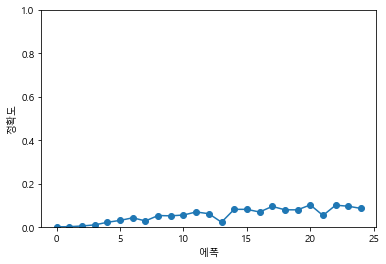

In [7]:
# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

## Seq2seq 개선

### [1] 입력 데이터의 순서를 반전 시키면 학습 진행이 빨라져서 최종 정확도가 향상된다

In [6]:
(x_train,t_train),(x_test,t_test) = sequence.load_data('addition.txt', seed = 1984)
char_to_id ,id_to_char = sequence.get_vocab()

print('원본:',x_train[0],x_test[0])

# 입력 반전 여부 설정
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:,::-1],x_test[:,::-1] # 열의 순서를 거꾸로 변경
    
print('반전:',x_train[0],x_test[0])

원본: [ 3  0  2  0  0 11  5] [ 3  3  2 11  4  5  5]
반전: [ 5 11  0  0  2  0  3] [ 5  5  4 11  2  3  3]


In [9]:
# 하이퍼 파라미터 설정
vocab_size = len(char_to_id)  # 13개
wordvec_size = 16
hidden_size = 128
batch_size = 128

max_epoch = 25
max_grad = 5.0

model = Seq2seq(vocab_size,wordvec_size,hidden_size)

optimizer = Adam()
trainer = Trainer(model,optimizer)

acc_list = []

for epoch in range(max_epoch): # 25회
    trainer.fit(x_train,t_train,max_epoch=1,
                batch_size=batch_size,max_grad=max_grad)
    
    correct_num = 0
    
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10  # 최초 10개만 맞았는지 틀렸는지  출력
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))
    
# 약 6~7분 소요 
# 검증 정확도향상  8.620% ==> 54.280%

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 4[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 6[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 7[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 8[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 9[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 11[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 12[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 13[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 15[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 16[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 17[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 19[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 20[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 21[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1001
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1001
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---

| 에폭 8 |  반복 341 / 351 | 시간 21[s] | 손실 0.57
Q 77+85  
T 162 
X 163 
---
Q 975+164
T 1139
X 1134
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
X 162 
---
Q 367+55 
T 422 
X 423 
---
Q 600+257
T 857 
X 759 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
X 1431
---
Q 26+838 
T 864 
X 866 
---
Q 143+93 
T 236 
X 238 
---
검증 정확도 23.080%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.55
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 0.56
| 에폭 9 |  반복 41 / 351 | 시간 4[s] | 손실 0.56
| 에폭 9 |  반복 61 / 351 | 시간 5[s] | 손실 0.55
| 에폭 9 |  반복 81 / 351 | 시간 7[s] | 손실 0.54
| 에폭 9 |  반복 101 / 351 | 시간 8[s] | 손실 0.55
| 에폭 9 |  반복 121 / 351 | 시간 10[s] | 손실 0.55
| 에폭 9 |  반복 141 / 351 | 시간 11[s] | 손실 0.54
| 에폭 9 |  반복 161 / 351 | 시간 13[s] | 손실 0.55
| 에폭 9 |  반복 181 / 351 | 시간 14[s] | 손실 0.53
| 에폭 9 |  반복 201 / 351 | 시간 16[s] | 손실 0.54
| 에폭 9 |  반복 221 / 351 | 시간 17[s] | 손실 0.54
| 에폭 9 |  반복 241 / 351 | 시간 18[s] | 손실 0.53
| 에폭 9 |  반복 261 / 351 | 시간 20[s] | 손실 0.53
| 에폭 9 |  반복 281 / 351 | 시간 21[s] | 손실 0.54
| 에폭 9 |  반복 

| 에폭 16 |  반복 121 / 351 | 시간 7[s] | 손실 0.37
| 에폭 16 |  반복 141 / 351 | 시간 8[s] | 손실 0.36
| 에폭 16 |  반복 161 / 351 | 시간 9[s] | 손실 0.37
| 에폭 16 |  반복 181 / 351 | 시간 11[s] | 손실 0.36
| 에폭 16 |  반복 201 / 351 | 시간 12[s] | 손실 0.38
| 에폭 16 |  반복 221 / 351 | 시간 13[s] | 손실 0.38
| 에폭 16 |  반복 241 / 351 | 시간 14[s] | 손실 0.36
| 에폭 16 |  반복 261 / 351 | 시간 16[s] | 손실 0.35
| 에폭 16 |  반복 281 / 351 | 시간 17[s] | 손실 0.35
| 에폭 16 |  반복 301 / 351 | 시간 18[s] | 손실 0.35
| 에폭 16 |  반복 321 / 351 | 시간 19[s] | 손실 0.35
| 에폭 16 |  반복 341 / 351 | 시간 21[s] | 손실 0.37
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1142
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 858 
---
Q 761+292
T 1053
X 1054
---
Q 830+597
T 1427
X 1430
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
X 237 
---
검증 정확도 42.700%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.34
| 에폭 17 |  반복 21 / 351 | 시간 1[s] | 손실 0.36
| 에폭 17 |  반복 41 / 351 | 시간 2[s] | 손실 0.36
| 에폭 17 |  반복 61 / 351 | 시간 3[s] | 손실 0.

검증 정확도 45.160%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.31
| 에폭 24 |  반복 21 / 351 | 시간 1[s] | 손실 0.29
| 에폭 24 |  반복 41 / 351 | 시간 2[s] | 손실 0.28
| 에폭 24 |  반복 61 / 351 | 시간 3[s] | 손실 0.29
| 에폭 24 |  반복 81 / 351 | 시간 4[s] | 손실 0.30
| 에폭 24 |  반복 101 / 351 | 시간 5[s] | 손실 0.29
| 에폭 24 |  반복 121 / 351 | 시간 6[s] | 손실 0.29
| 에폭 24 |  반복 141 / 351 | 시간 7[s] | 손실 0.29
| 에폭 24 |  반복 161 / 351 | 시간 8[s] | 손실 0.28
| 에폭 24 |  반복 181 / 351 | 시간 9[s] | 손실 0.29
| 에폭 24 |  반복 201 / 351 | 시간 10[s] | 손실 0.28
| 에폭 24 |  반복 221 / 351 | 시간 12[s] | 손실 0.28
| 에폭 24 |  반복 241 / 351 | 시간 13[s] | 손실 0.29
| 에폭 24 |  반복 261 / 351 | 시간 14[s] | 손실 0.29
| 에폭 24 |  반복 281 / 351 | 시간 15[s] | 손실 0.29
| 에폭 24 |  반복 301 / 351 | 시간 16[s] | 손실 0.28
| 에폭 24 |  반복 321 / 351 | 시간 17[s] | 손실 0.27
| 에폭 24 |  반복 341 / 351 | 시간 18[s] | 손실 0.29
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
X 421 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
X 1054

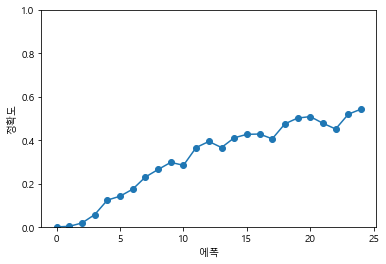

In [10]:
# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

### [2] Peeky Seq2Seq : Peeky Decoder 사용
 Encoder의 출력 h를 Decoder의 다른 계층에게도 함께 전달해준다 (집단지성)<br>
 모든 Time의 LSTM 계층과 Affine 계층에 Encoder의 출력 h를 전해준다 

In [8]:
# Encoder는 앞의 Encoder를 그대로 사용한다
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size ):
        V,D,H = vocab_size, wordvec_size,hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V,D) / 100).astype('f')       
        lstm_Wx = (rn(D + H,4*H) / np.sqrt(D + H)).astype('f') # D --> D + H,concat으로 인하여 H만큼 추가됨
        lstm_Wh = (rn(H,4*H) / np.sqrt(H)).astype('f') 
        lstm_b = np.zeros(4*H).astype('f')  

        affine_W = (rn(H + H,V) / np.sqrt(H + H)).astype('f') # H --> H + H,concat으로 인하여 H만큼 추가됨
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx,lstm_Wh,lstm_b,stateful=True)  
        self.affine = TimeAffine(affine_W,affine_b)
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params,self.grads = [],[]
        for layer in (self.embed,self.lstm,self.affine):
            self.params += layer.params
            self.grads += layer.grads
            
        self.cache = None
        
    # 학습시 호출
    def forward(self,xs,h):           # h : Encoder의 출력, (N,H)
        N,T = xs.shape
        N,H = h.shape
        
        self.lstm.set_state(h)     
        out = self.embed.forward(xs)    # (N,T,D)
        
        hs = np.repeat(h,T,axis = 0).reshape(N,T,H) # 입력된 h를 시계열 갯수 만큼 복제한다
        out = np.concatenate((hs,out),axis=2)       # (N,T,H+D), Embedding 계층 출력과 hs를 concatenate한다
        
        out = self.lstm.forward(out)                # (N,T,H) ,  LSTM 계층의 forward에 합쳐진 out을 전달
        
        out = np.concatenate((hs,out),axis=2)       # (N,T,H+H), LSTM 계층 출력과 hs를 concatenate한다
        score = self.affine.forward(out)            # Affine계층의 forward에 합쳐진 out을 전달
        
        self.cache = H
        return score     
    
    def backward(self,dscore):
        H = self.cache
        
        dout = self.affine.backward(dscore)
        dhs0, dout = dout[:,:,:H],dout[:,:,H:]   # concatenate의 반대 slicing
        dout = self.lstm.backward(dout)

        dhs1, dout = dout[:,:,:H],dout[:,:,H:]   # concatenate의 반대 slicing
        dout = self.embed.backward(dout)         # (N,T,D)
        
        dhs = dhs0 + dhs1 # Affine의 backward 출력 dhs0과 LSTM의 backward 출력 dhs1을 더한다(branch의 반대)
        
        dh = self.lstm.dh + np.sum(dhs,axis=1)  # (N,H) , LSTM의 backward출력 dh와 dhs의 수평합과 더한다, 최종 출력값
        return dh             # Encoder 에 전달 
    
     # 문장 생성시 호출   
    def generate(self,h,start_id,sample_size) :  # h: (N,H)
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)
        
        H = h.shape[1]
        peeky_h = h.reshape(1,1,H)
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape(1,1)
            out = self.embed.forward(x)
            
            out = np.concatenate((peeky_h,out),axis=2) # 입력된 peeky_h를 Embedding 계층 출력과 concatenate한다
            out = self.lstm.forward(out) 
            
            out = np.concatenate((peeky_h,out),axis=2) # 입력된 peeky_h를 LSTM 계층 출력과 concatenate한다
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())     # 점수가 가장 큰 문자의 ID를 선택,결정적 방법
            sampled.append(int(sample_id))
            
        return sampled        
            

In [9]:
# PeekySeq2seq class  : Seq2seq class를 상속 받아서 구현
# forward(),backward(),generate() 메서드는 Seq2seq class와 모두 동일
class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V,D,H = vocab_size, wordvec_size, hidden_size
        
        self.encoder = Encoder(V,D,H)
        self.decoder = PeekyDecoder(V,D,H)   # PeekyDecoder사용,이 부분만 Seq2seq클래스와 다르다
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

### 학습 코드 구현

In [13]:
from nn_layers import Adam,Trainer,TimeEmbedding,TimeLSTM,TimeAffine,TimeSoftmaxWithLoss
import matplotlib.pyplot as plt
from dataset import sequence
import numpy as np

(x_train,t_train),(x_test,t_test) = sequence.load_data('addition.txt', seed = 1984)
char_to_id ,id_to_char = sequence.get_vocab()

print('원본:',x_train[0],x_test[0])

# 입력 반전 여부 설정
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:,::-1],x_test[:,::-1] # 열의 순서를 거꾸로 변경
    
print('반전:',x_train[0],x_test[0])

# 하이퍼 파라미터 설정
vocab_size = len(char_to_id)  # 13개
wordvec_size = 16
hidden_size = 128
batch_size = 128

max_epoch = 25
max_grad = 5.0

model = PeekySeq2seq(vocab_size,wordvec_size,hidden_size)

optimizer = Adam()
trainer = Trainer(model,optimizer)

acc_list = []

for epoch in range(max_epoch): # 25회
    trainer.fit(x_train,t_train,max_epoch=1,
                batch_size=batch_size,max_grad=max_grad)
    
    correct_num = 0
    
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10  # 최초 10개만 맞았는지 틀렸는지  출력
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))
    
# 약 6~7분 소요 
# 검증 정확도  99.3% ==> 정확도가 크게 향상

원본: [ 3  0  2  0  0 11  5] [ 3  3  2 11  4  5  5]
반전: [ 5 11  0  0  2  0  3] [ 5  5  4 11  2  3  3]
| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 4[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 5[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 7[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 8[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 10[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 12[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 15[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 17[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 19[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 20[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 23[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 25[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 27[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 28[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 30[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+84 
T 666 
X 102 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 

| 에폭 8 |  반복 281 / 351 | 시간 19[s] | 손실 0.36
| 에폭 8 |  반복 301 / 351 | 시간 20[s] | 손실 0.36
| 에폭 8 |  반복 321 / 351 | 시간 21[s] | 손실 0.35
| 에폭 8 |  반복 341 / 351 | 시간 23[s] | 손실 0.34
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
X 657 
---
Q 8+155  
T 163 
X 155 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
X 1438
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 65.040%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.32
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 0.31
| 에폭 9 |  반복 41 / 351 | 시간 3[s] | 손실 0.31
| 에폭 9 |  반복 61 / 351 | 시간 4[s] | 손실 0.31
| 에폭 9 |  반복 81 / 351 | 시간 5[s] | 손실 0.29
| 에폭 9 |  반복 101 / 351 | 시간 6[s] | 손실 0.29
| 에폭 9 |  반복 121 / 351 | 시간 8[s] | 손실 0.29
| 에폭 9 |  반복 141 / 351 | 시간 9[s] | 손실 0.27
| 에폭 9 |  반복 161 / 351 | 시간 10[s] | 손실 0.27
| 에폭 9 |  반복 181 / 351 | 시간 12[s] | 손실 0.26
| 에폭 9 |  반복 201 / 351 | 시간 14[s] | 손실 0.25
| 에폭 9 |  반복 221 / 351 | 시간 15[s] | 손실 0.25
| 에폭 9 |  반복 24

| 에폭 16 |  반복 61 / 351 | 시간 4[s] | 손실 0.06
| 에폭 16 |  반복 81 / 351 | 시간 5[s] | 손실 0.05
| 에폭 16 |  반복 101 / 351 | 시간 6[s] | 손실 0.04
| 에폭 16 |  반복 121 / 351 | 시간 7[s] | 손실 0.04
| 에폭 16 |  반복 141 / 351 | 시간 9[s] | 손실 0.04
| 에폭 16 |  반복 161 / 351 | 시간 10[s] | 손실 0.03
| 에폭 16 |  반복 181 / 351 | 시간 11[s] | 손실 0.04
| 에폭 16 |  반복 201 / 351 | 시간 12[s] | 손실 0.03
| 에폭 16 |  반복 221 / 351 | 시간 14[s] | 손실 0.03
| 에폭 16 |  반복 241 / 351 | 시간 15[s] | 손실 0.03
| 에폭 16 |  반복 261 / 351 | 시간 16[s] | 손실 0.03
| 에폭 16 |  반복 281 / 351 | 시간 17[s] | 손실 0.03
| 에폭 16 |  반복 301 / 351 | 시간 19[s] | 손실 0.03
| 에폭 16 |  반복 321 / 351 | 시간 20[s] | 손실 0.03
| 에폭 16 |  반복 341 / 351 | 시간 22[s] | 손실 0.04
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 97.180%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 

| 에폭 23 |  반복 321 / 351 | 시간 19[s] | 손실 0.02
| 에폭 23 |  반복 341 / 351 | 시간 20[s] | 손실 0.02
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 98.460%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.01
| 에폭 24 |  반복 21 / 351 | 시간 1[s] | 손실 0.01
| 에폭 24 |  반복 41 / 351 | 시간 2[s] | 손실 0.01
| 에폭 24 |  반복 61 / 351 | 시간 3[s] | 손실 0.01
| 에폭 24 |  반복 81 / 351 | 시간 4[s] | 손실 0.02
| 에폭 24 |  반복 101 / 351 | 시간 5[s] | 손실 0.01
| 에폭 24 |  반복 121 / 351 | 시간 7[s] | 손실 0.02
| 에폭 24 |  반복 141 / 351 | 시간 8[s] | 손실 0.04
| 에폭 24 |  반복 161 / 351 | 시간 9[s] | 손실 0.05
| 에폭 24 |  반복 181 / 351 | 시간 10[s] | 손실 0.06
| 에폭 24 |  반복 201 / 351 | 시간 11[s] | 손실 0.05
| 에폭 24 |  반복 221 / 351 | 시간 12[s] | 손실 0.03
| 에폭 24 |  반복 241 / 351 | 시간 14[s] | 손실 0.03
| 에폭 24 |  반복 261 / 351 | 시간 15[s] | 손실 0.04


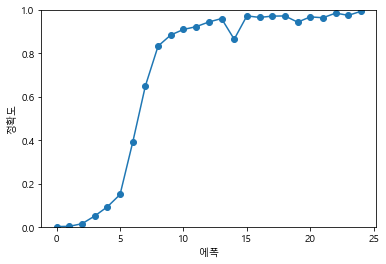

In [14]:
# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()